In [1]:
import warnings
import gzip
import ujson

import pandas as pd
import numpy as np

from glob import glob
from itertools import islice
from tqdm import tqdm
from boltons.iterutils import windowed
from collections import Counter

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

from news_vec import logger
from news_vec.title_clf import clean_headline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
warnings.simplefilter('ignore')

In [12]:
class Line:

    def __init__(self, tokens, label, lower=True):
        self.tokens = [t.lower() for t in tokens] if lower else tokens
        self.label = label

    def __repr__(self):

        pattern = '{cls_name}<{token_count} tokens -> {label}>'

        return pattern.format(
            cls_name=self.__class__.__name__,
            token_count=len(self.tokens),
            label=self.label,
        )
    
    def ngrams(self, n):
        return windowed(self.tokens, n)
                
    def ngram_keys_iter(self, n, vocab=None):
        for ng in self.ngrams(n):
            if not vocab or ng in vocab:
                yield '_' + '_'.join(ng)
                
    def ngram_counts_iter(self, n, vocab=None):
        yield from Counter(self.ngram_keys_iter(n, vocab)).items()
    
    def features_iter(self, vocab):
        yield from self.ngram_counts_iter(1, vocab)
        yield from self.ngram_counts_iter(2, vocab)
        yield from self.ngram_counts_iter(3, vocab)
        yield ('wc', len(self.tokens))
        
    def x(self, vocab):
        return dict(self.features_iter(vocab))

In [13]:
def read_json_lines(root, lower=True):
    """Generate links from a JSON corpus.

    Yields: list<str>
    """
    for path in glob('%s/*.gz' % root):
        with gzip.open(path) as fh:
            for line in fh:

                data = ujson.loads(line)

                tokens = data.get('tokens')
                tokens = clean_headline(tokens)

                if not tokens:
                    continue

                yield Line(tokens, data['label'], lower=lower)

In [17]:
class Corpus:

    def __init__(self, root, skim=None, lower=True):
        """Read lines.
        """
        logger.info('Parsing line corpus.')

        lines_iter = islice(read_json_lines(root, lower), skim)

        self.lines = list(tqdm(lines_iter))

    def __repr__(self):

        pattern = '{cls_name}<{line_count} lines>'

        return pattern.format(
            cls_name=self.__class__.__name__,
            line_count=len(self),
        )

    def __len__(self):
        return len(self.lines)

    def __iter__(self):
        return iter(self.lines)
    
    def ngram_counts(self, n):
        """Collect all ngram -> count.
        """
        logger.info('Gathering %d-gram counts.' % n)

        counts = Counter()
        for line in tqdm(self):
            counts.update(line.ngrams(n))

        return counts

    def topk_ngrams(self, n, k):
        counts = self.ngram_counts(n)
        return [ng for ng, _ in counts.most_common(k)]
    
    def x_iter(self, vocab):
        for line in tqdm(self):
            yield line.x(vocab)

In [29]:
c = Corpus('../data/titles-50k.json/')

2018-11-30 15:24:34,891 | INFO : Parsing line corpus.
2123078it [00:53, 39500.39it/s]


In [30]:
vocab = set(
    c.topk_ngrams(1, 5000) +
    c.topk_ngrams(2, 5000) +
    c.topk_ngrams(3, 5000)
)

2018-11-30 15:25:28,656 | INFO : Gathering 1-gram counts.
100%|██████████| 2123078/2123078 [00:15<00:00, 133497.10it/s]
2018-11-30 15:25:44,625 | INFO : Gathering 2-gram counts.
100%|██████████| 2123078/2123078 [00:24<00:00, 86164.16it/s]
2018-11-30 15:26:10,088 | INFO : Gathering 3-gram counts.
100%|██████████| 2123078/2123078 [00:23<00:00, 91753.14it/s]


In [31]:
xs = list(c.x_iter(vocab))

100%|██████████| 2123078/2123078 [01:09<00:00, 30504.97it/s]


In [32]:
dv = DictVectorizer()
X = dv.fit_transform(xs)

In [33]:
X

<2123078x15001 sparse matrix of type '<class 'numpy.float64'>'
	with 25264178 stored elements in Compressed Sparse Row format>

In [34]:
y = [line.label for line in c]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [36]:
model = LogisticRegression(verbose=True, multi_class='multinomial', solver='sag', n_jobs=-1)

In [37]:
fit = model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


max_iter reached after 640 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 10.7min finished


In [38]:
y_pred = fit.predict(X_test)

In [39]:
print(metrics.classification_report(y_test, y_pred))

                        precision    recall  f1-score   support

            apnews.com       0.16      0.18      0.17     10094
             bbc.co.uk       0.33      0.41      0.36     10055
         bloomberg.com       0.30      0.29      0.29     10178
         breitbart.com       0.22      0.24      0.23     10133
   businessinsider.com       0.28      0.34      0.30     10242
          buzzfeed.com       0.44      0.60      0.51     10057
                cbc.ca       0.38      0.48      0.42     10102
           cbsnews.com       0.16      0.12      0.14     10269
              cnbc.com       0.29      0.28      0.28     10057
               cnn.com       0.17      0.06      0.09     10241
       dailycaller.com       0.26      0.22      0.24     10207
          dailykos.com       0.31      0.39      0.34     10205
            forbes.com       0.22      0.28      0.24     10043
           foxnews.com       0.15      0.08      0.11     10013
                ft.com       0.30      

In [40]:
cm = metrics.confusion_matrix(y_test, y_pred, labels=fit.classes_)
cm = cm / cm.sum(1)

In [44]:
np.fill_diagonal(cm, 0)

In [45]:
rows = [
    (fit.classes_[x], fit.classes_[y], cm[x, y])
    for x in range(cm.shape[0])
    for y in range(cm.shape[1])
]

In [46]:
cm_df = pd.DataFrame(rows, columns=('x', 'y', 'z'))

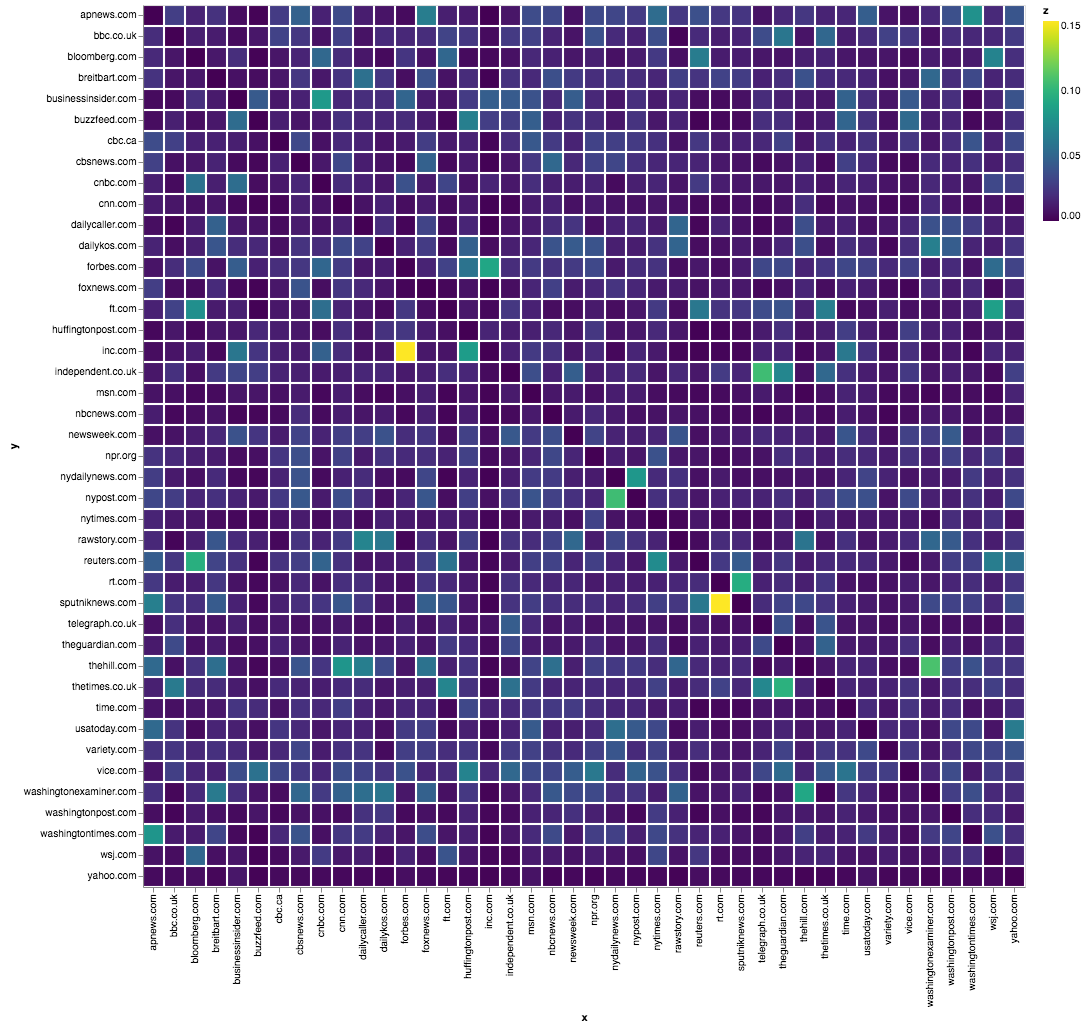

In [47]:
alt.Chart(cm_df).mark_rect().encode(x='x:O', y='y:O', color='z:Q', tooltip='x')